In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model
from tfspline import plot
from tfspline import sampledata
from tfspline import parallel

## Input data
To simplify choice of constants we shift and scale data such that values are in the [0, 1] range. Otherwise we would need to adapt learning rate and similar things. We skip the back-transformation as we would do in production code.

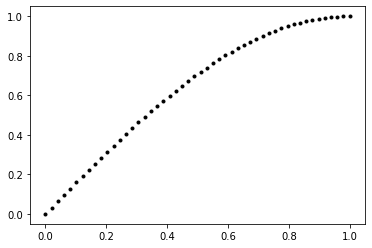

In [2]:
# Generate input data

data_x = np.linspace(0, 0.5*np.pi, 50)
data_y = np.sin(data_x)

# data_x = np.linspace(0, 1, 100)
# data_y = np.sin(data_x**2 * 4 * np.pi)

[data_x_norm, data_y_norm] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x_norm, data_y_norm, 'k.')

## Spline properties based on Stefan Huber's findings in "Polynomial approximation.ipynb"

### Learning rate

0.1

### Gradient regularization

SGD benefits from regularization while adaptive optimizers (Adam) do not.
However, the regularization does not have any negative effect with adaptive optimizers, so we will leave it on in both cases.

### Optimizers

We limit ourselves to SGD and Adam, as other optimizers fail for high learning rate (0.1) in our application.
SGD: nesterov = true, momentum = 0.95
Adam: beta1 = 0.9

### Polynomial degree

With Adam and SGD after we see best results with polynomial degree 5.

In [3]:
learning_rate_adam = 0.1
learning_rate_sgd = 0.1
gradient_regularization=True
deg=5
n=4
continuity=False
seg_overlap = 0
epochs=1000

## Helper functions

In [20]:
def plot_results(results, plot_ck_loss=True, save=False):
    if not plot_ck_loss:
        # Plot without derivative specific Ck-Loss
        for i in range(len(params)):
            fig, axes = plt.subplots(2, 2)
            fig.set_figwidth(12)
            fig.set_figheight(10)
            ep = np.linspace(0, epochs, epochs)

            spline = model.get_spline_from_coeffs(results[i][2], data_x, data_y, total_loss_values=results[i][1][0], e_loss_values=results[i][1][1], uniform_split=True, shift_polynomial_centers='mean')

            fig.suptitle('optimizer ' + results[i][0]['optimizer'] + ', $\lambda$ = ' + str(results[i][0]['param_value']), fontsize=16)
            axes[0,0].plot(data_x, data_y, '.', color="black")
            plot.plot_spline(spline, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,0])
            axes[0,0].set_title('Derivative 0')
            plot.plot_spline(spline, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,1])
            axes[0,1].set_title('Derivative 1')
            plot.plot_spline(spline, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1,0])
            axes[1,0].set_title('Derivative 2')
            axes[1,1].semilogy(results[i][1][0])
            axes[1,1].set_title('Total loss')
            axes[1,1].set_xlabel('epochs')
            if save:
                fig.savefig(results[i][0]['optimizer'] + str(results[i][0]['param_value']) + '.png', format='png')
    else:
        # Plot with Ck-Loss
        for i in range(len(params)):
            fig, axes = plt.subplots(2, 3)
            fig.set_figwidth(18)
            fig.set_figheight(10)
            ep = np.linspace(0, epochs, epochs)

            spline = model.get_spline_from_coeffs(results[i][2], data_x, data_y, total_loss_values=results[i][1][0], e_loss_values=results[i][1][1], uniform_split=True, shift_polynomial_centers='mean')

            fig.suptitle('optimizer ' + results[i][0]['optimizer'] + ', $\lambda$ = ' + str(results[i][0]['param_value']), fontsize=16)
            axes[0,0].plot(data_x, data_y, '.', color="black")
            plot.plot_spline(spline, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,0])
            axes[0,0].set_title('Derivative 0')
            plot.plot_spline(spline, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,1])
            axes[0,1].set_title('Derivative 1')
            plot.plot_spline(spline, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,2])
            axes[0,2].set_title('Derivative 2')
            axes[1,0].semilogy(results[i][1][1])
            axes[1,0].set_title('Approximation error loss')
            axes[1,0].set_xlabel('epochs')
            axes[1,1].semilogy(np.linspace(0, epochs, epochs), results[i][1][2])
            axes[1,1].set_title('$C^k$ error loss')
            axes[1,1].set_xlabel('epochs')
            axes[1,2].semilogy(results[i][1][0])
            axes[1,2].set_title('Total loss')
            axes[1,2].set_xlabel('epochs')
            if save:
                fig.savefig(results[i][0]['optimizer'] + str(results[i][0]['param_value']) + '.png', format='png')

## Investigating convergence of combined Ck-discontinuity and approximation error loss function


### Sweep parameters

In this experiment, we iterate $\lambda$ from $1$ to $0$ and observe the convergence behavior using Adam and SDG optimizers.

In [5]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'learning_rate': learning_rate_adam, 'degree': deg, 'polynum': n, 'continuity': continuity, 
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': gradient_regularization, 'mode': 'approx_ck'}

params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

pool1 = mp.Pool(mp.cpu_count())
results_adam = pool1.starmap(parallel.job, zip(params, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'learning_rate': learning_rate_adam, 'degree': deg, 'polynum': n, 'continuity': continuity,
        'optimizer': 'SGD', 'n_epochs': epochs, 'gradient_regularization': gradient_regularization, 'mode': 'approx_ck'}

pool2 = mp.Pool(mp.cpu_count())
results_sgd = pool2.starmap(parallel.job, zip(params, repeat(kwargs)))

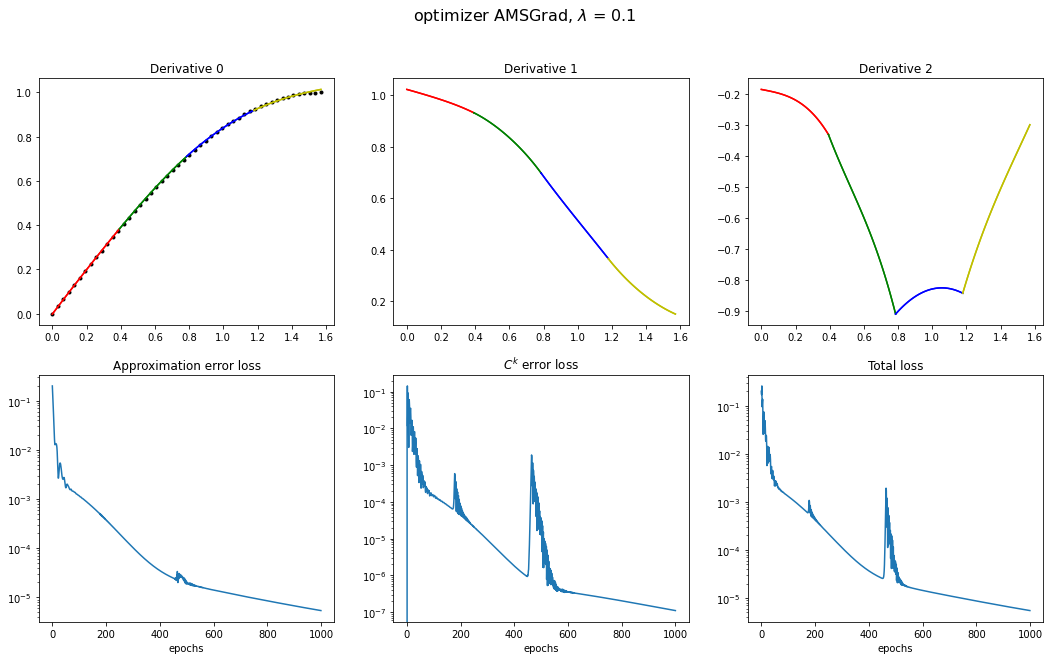

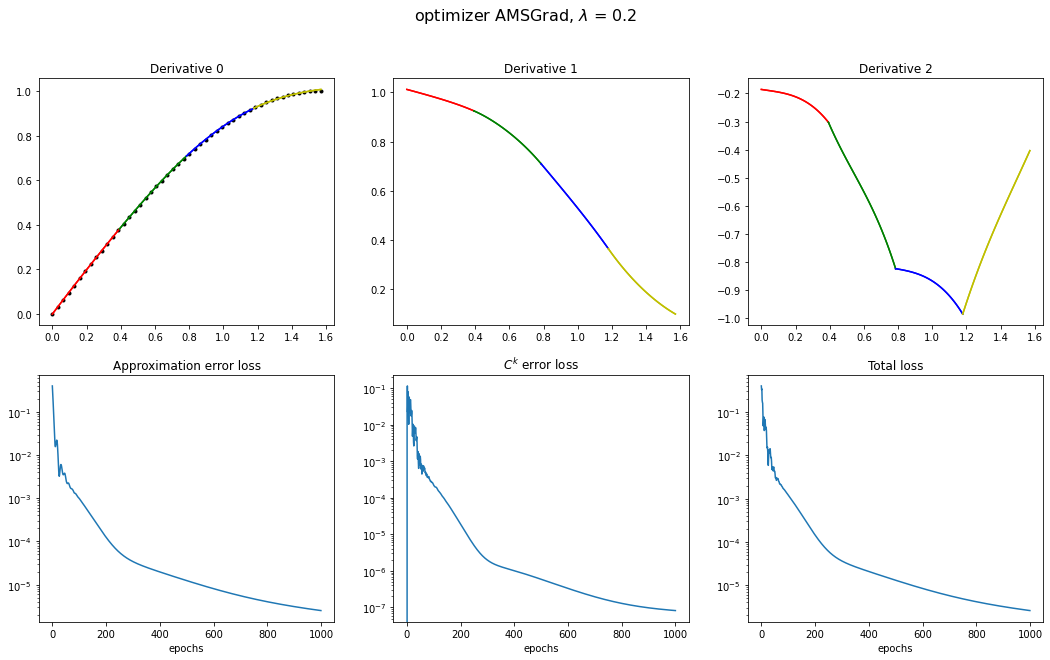

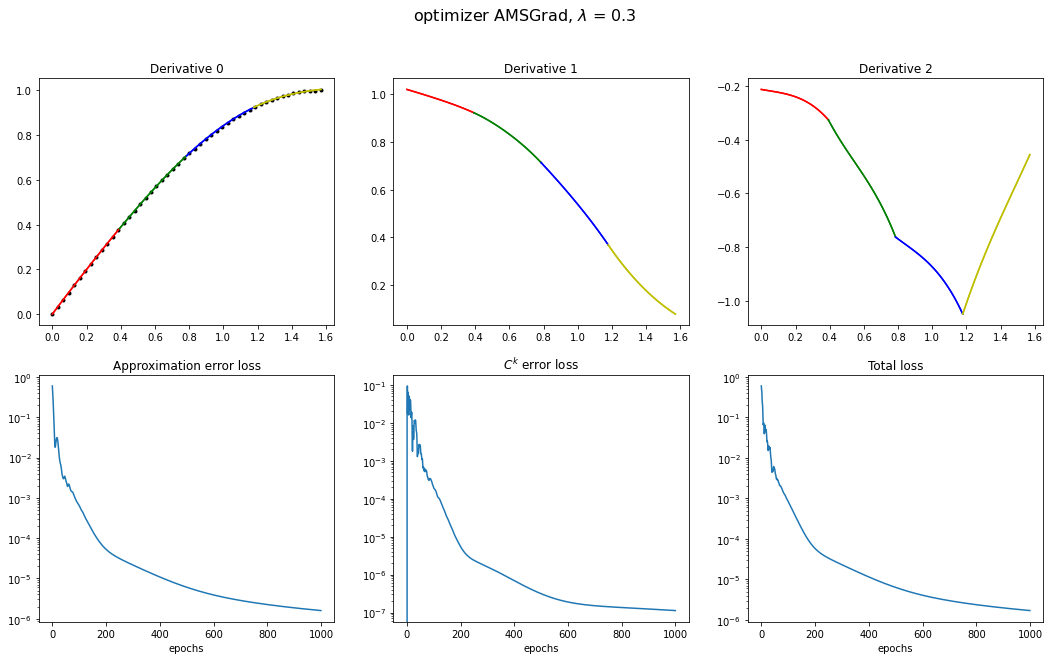

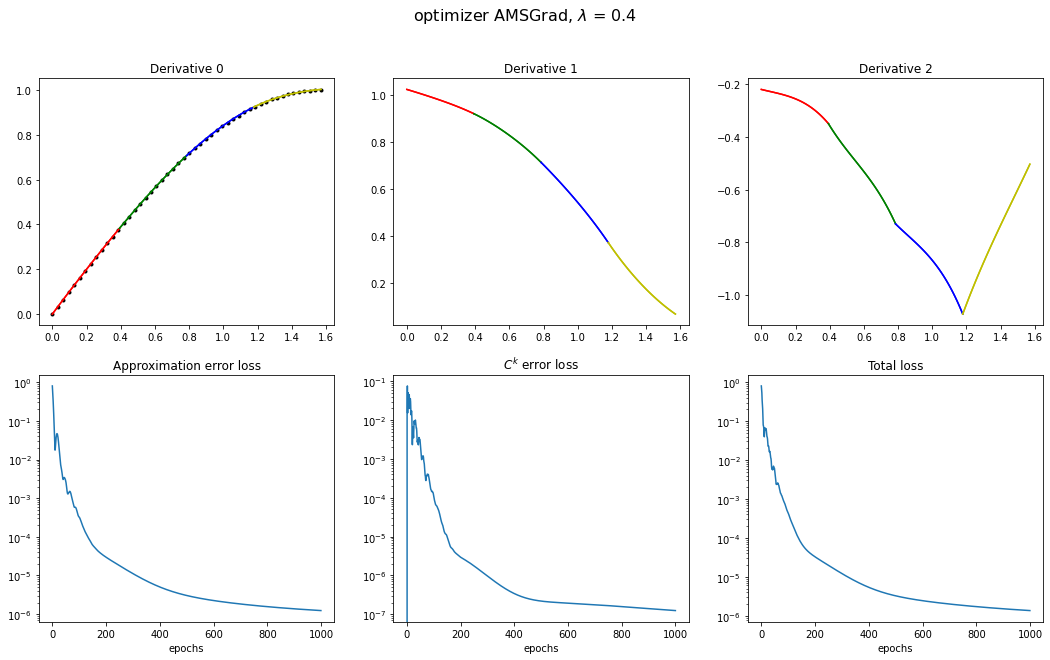

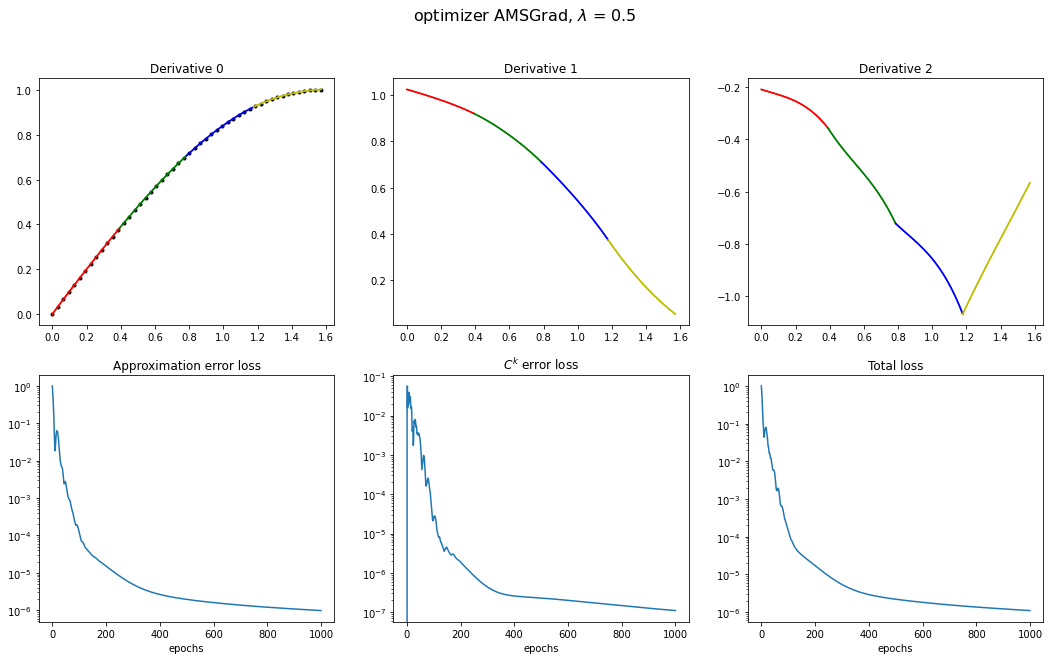

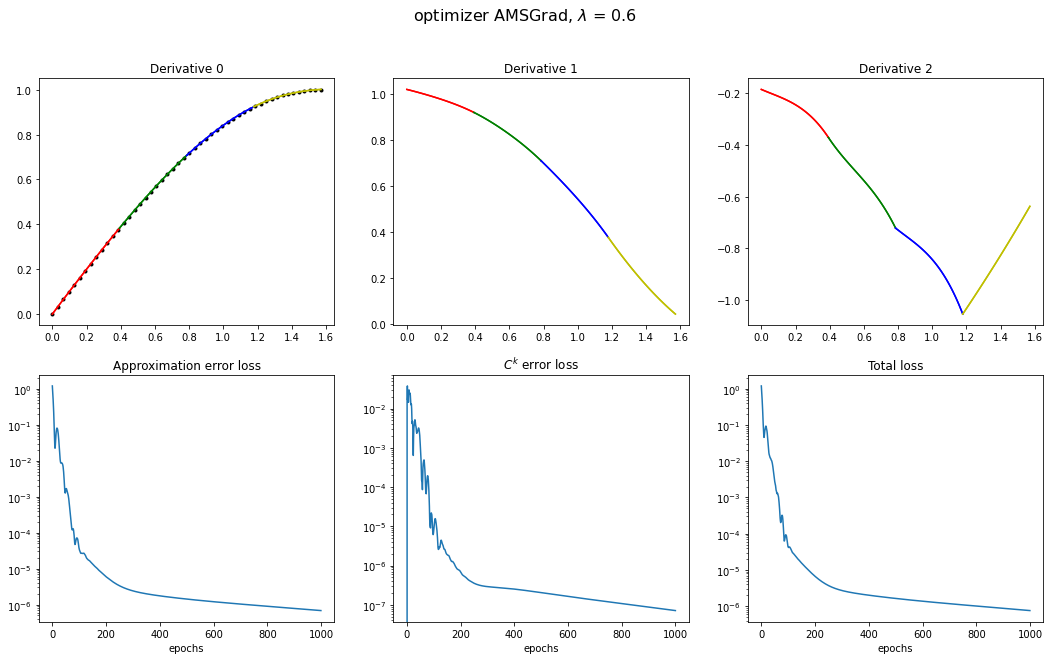

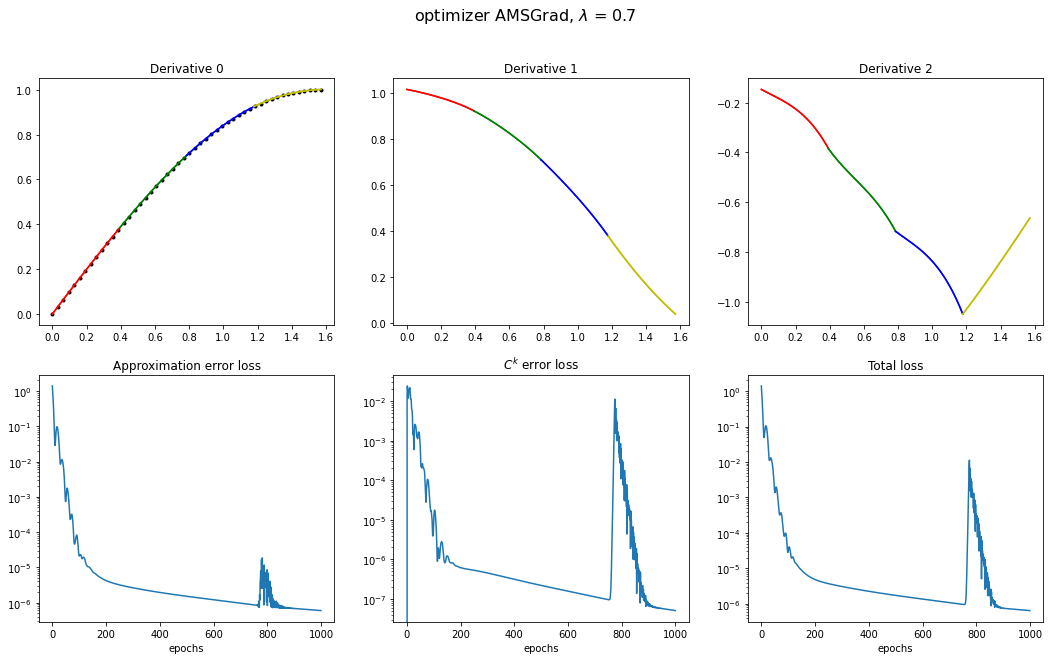

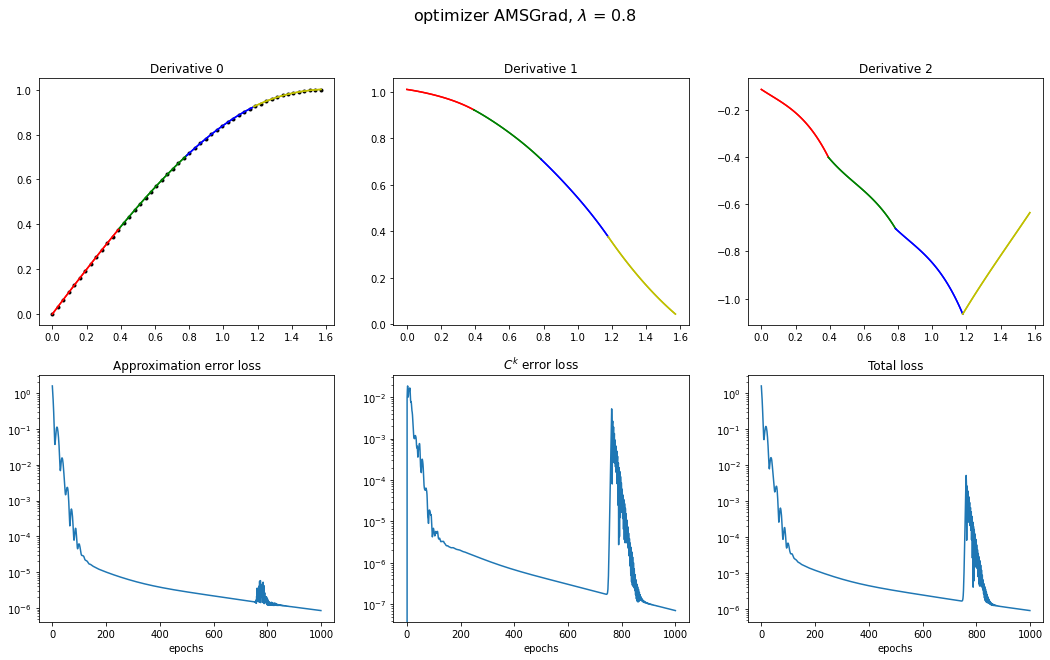

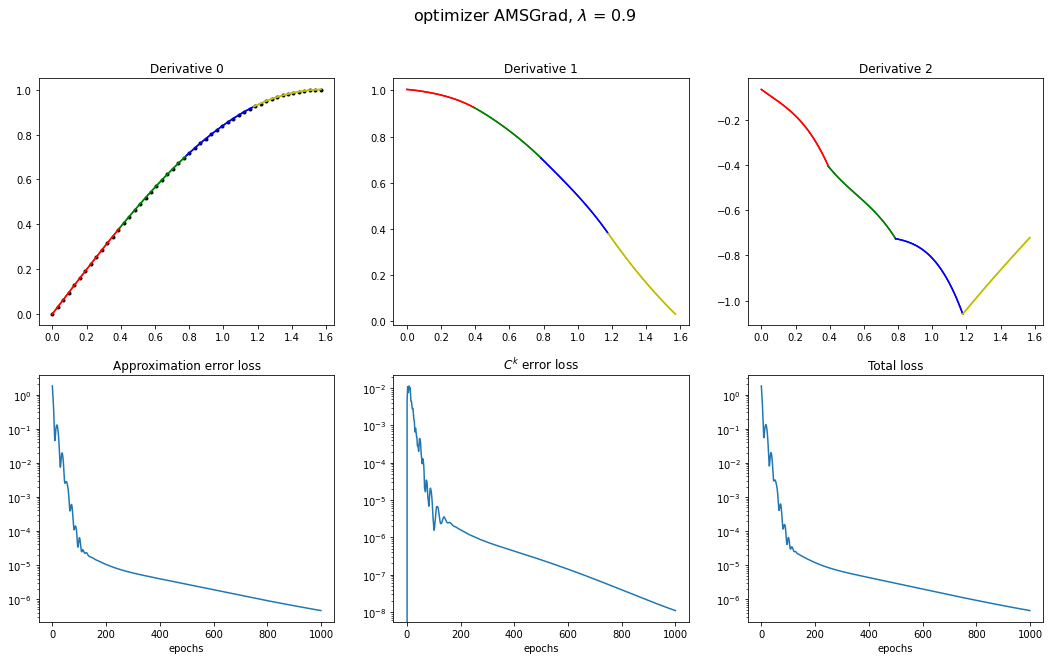

In [23]:
plot_results(results_adam)

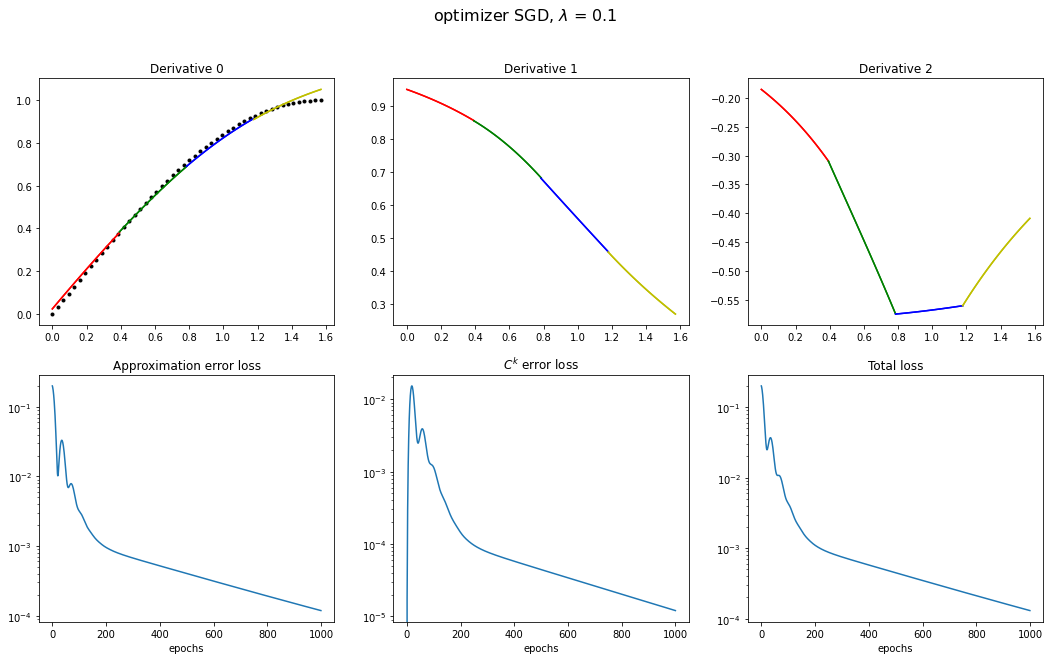

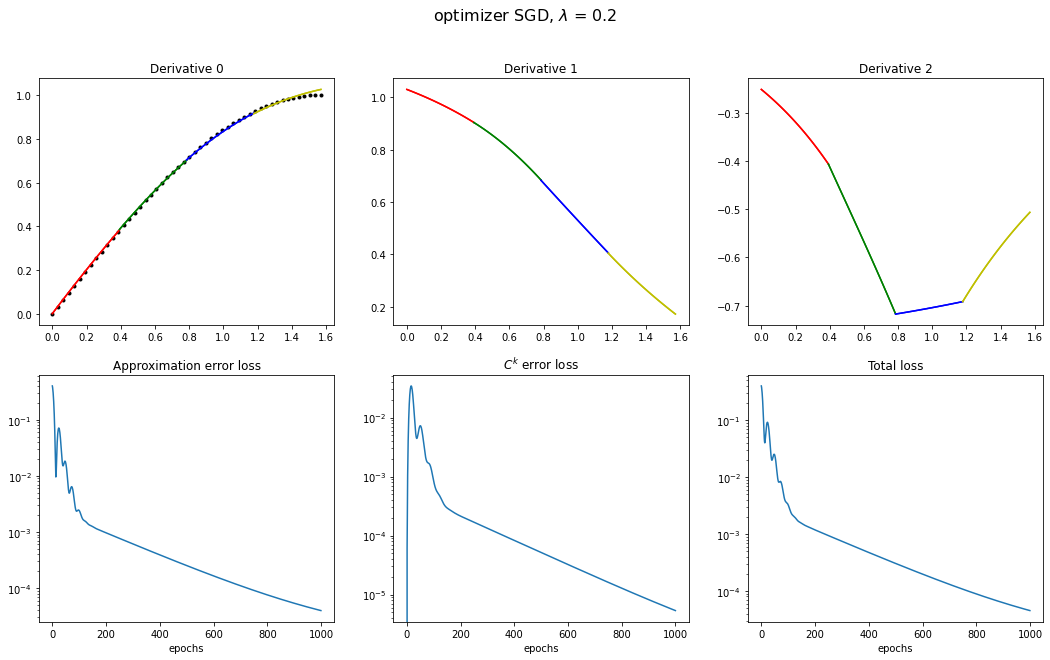

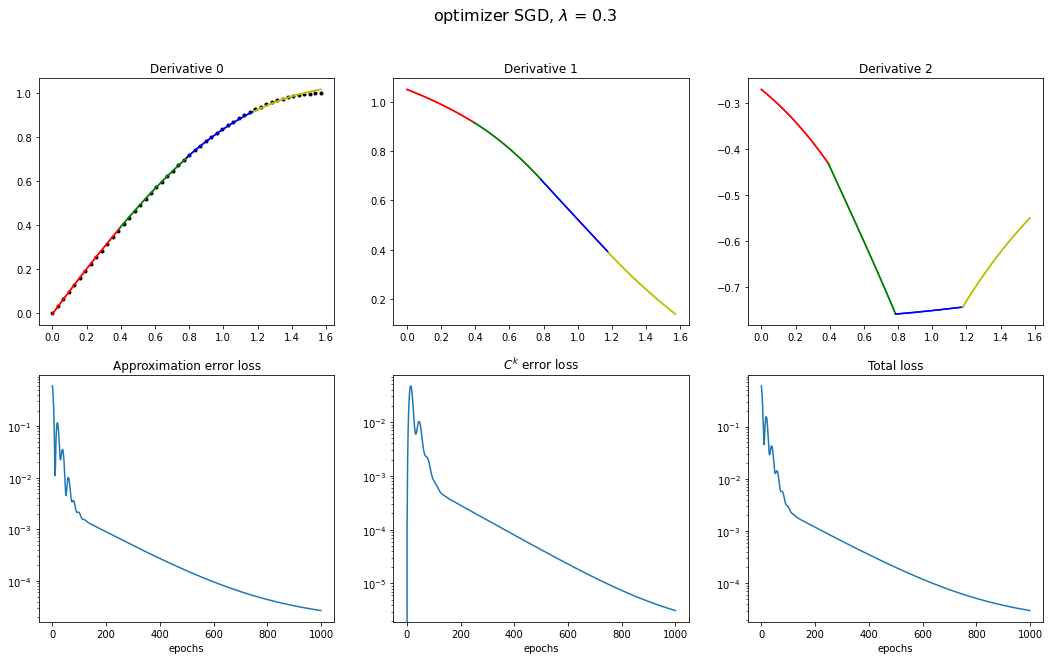

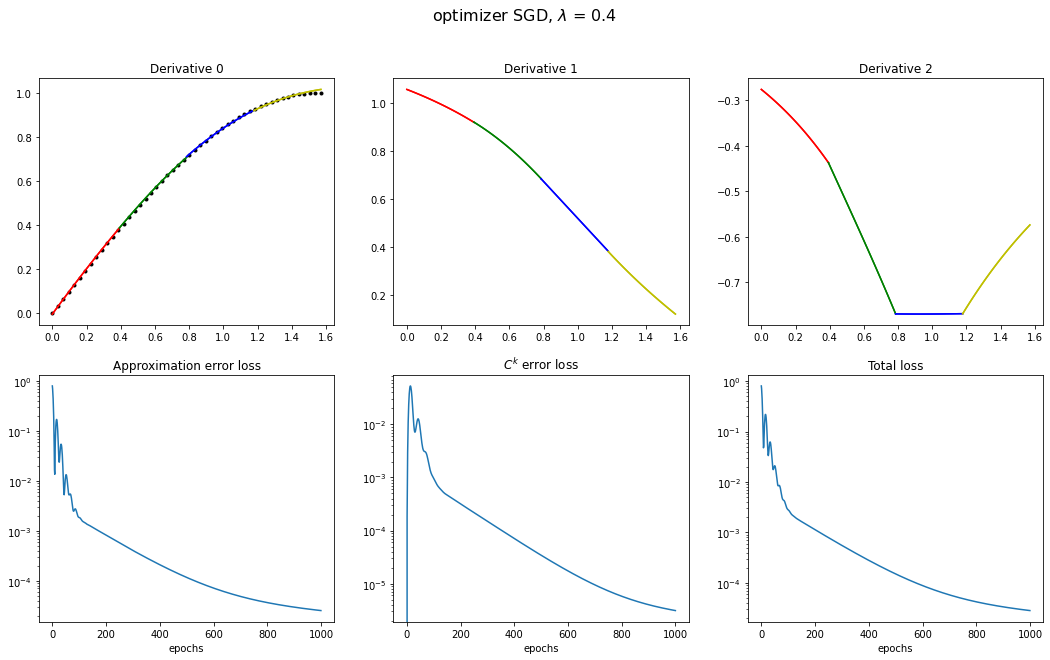

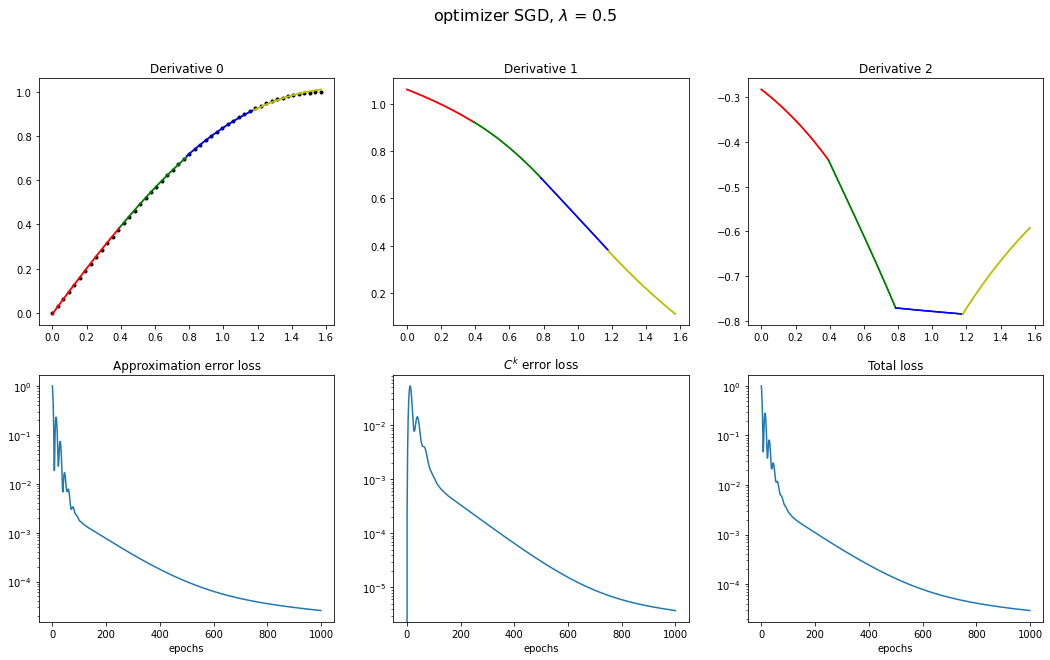

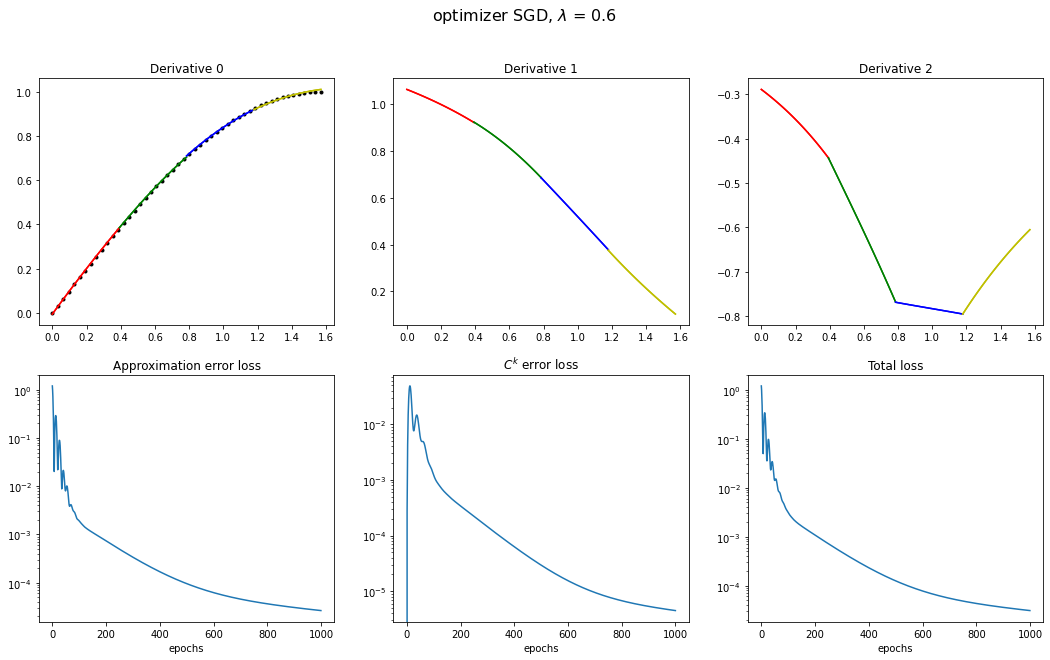

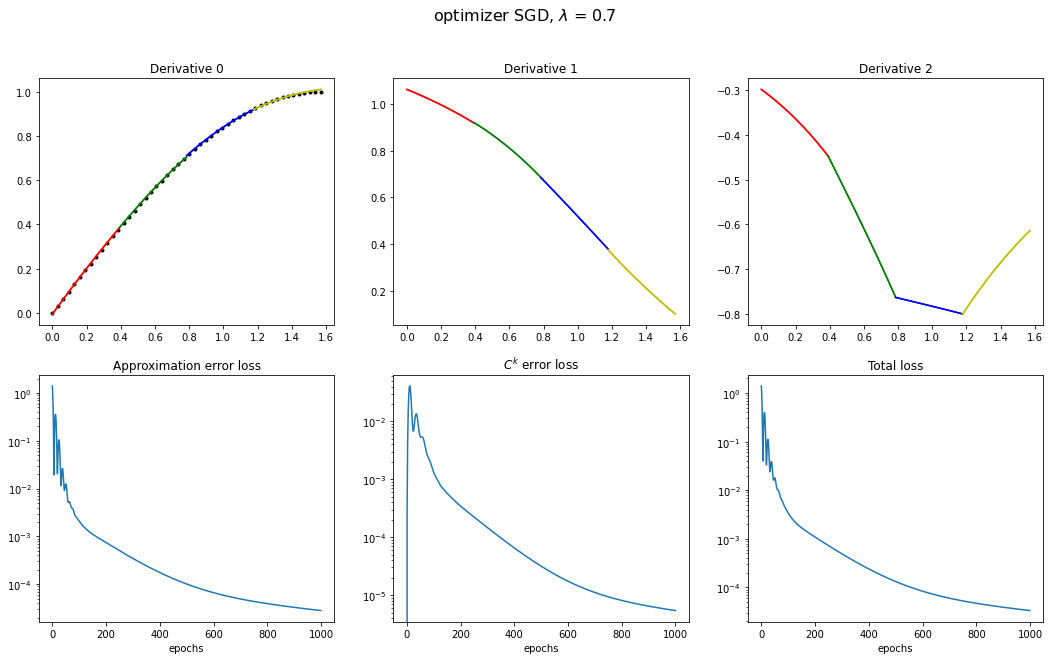

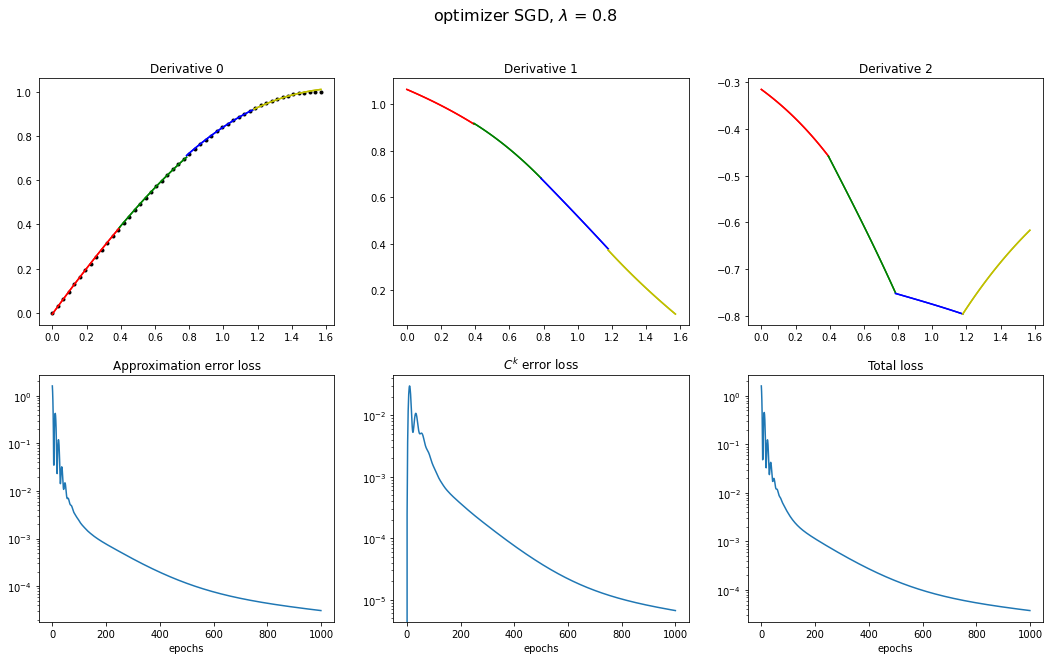

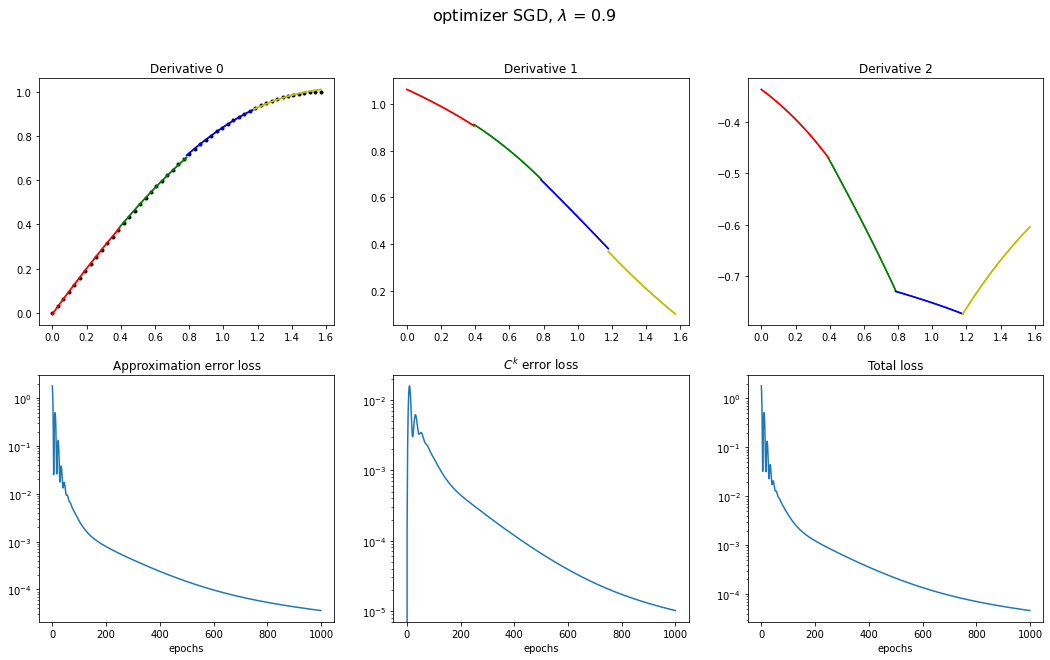

In [22]:
plot_results(results_sgd)

Text(0.5, 1.0, 'Optimizer AMSGrad: total loss over epoch for different lambdas')

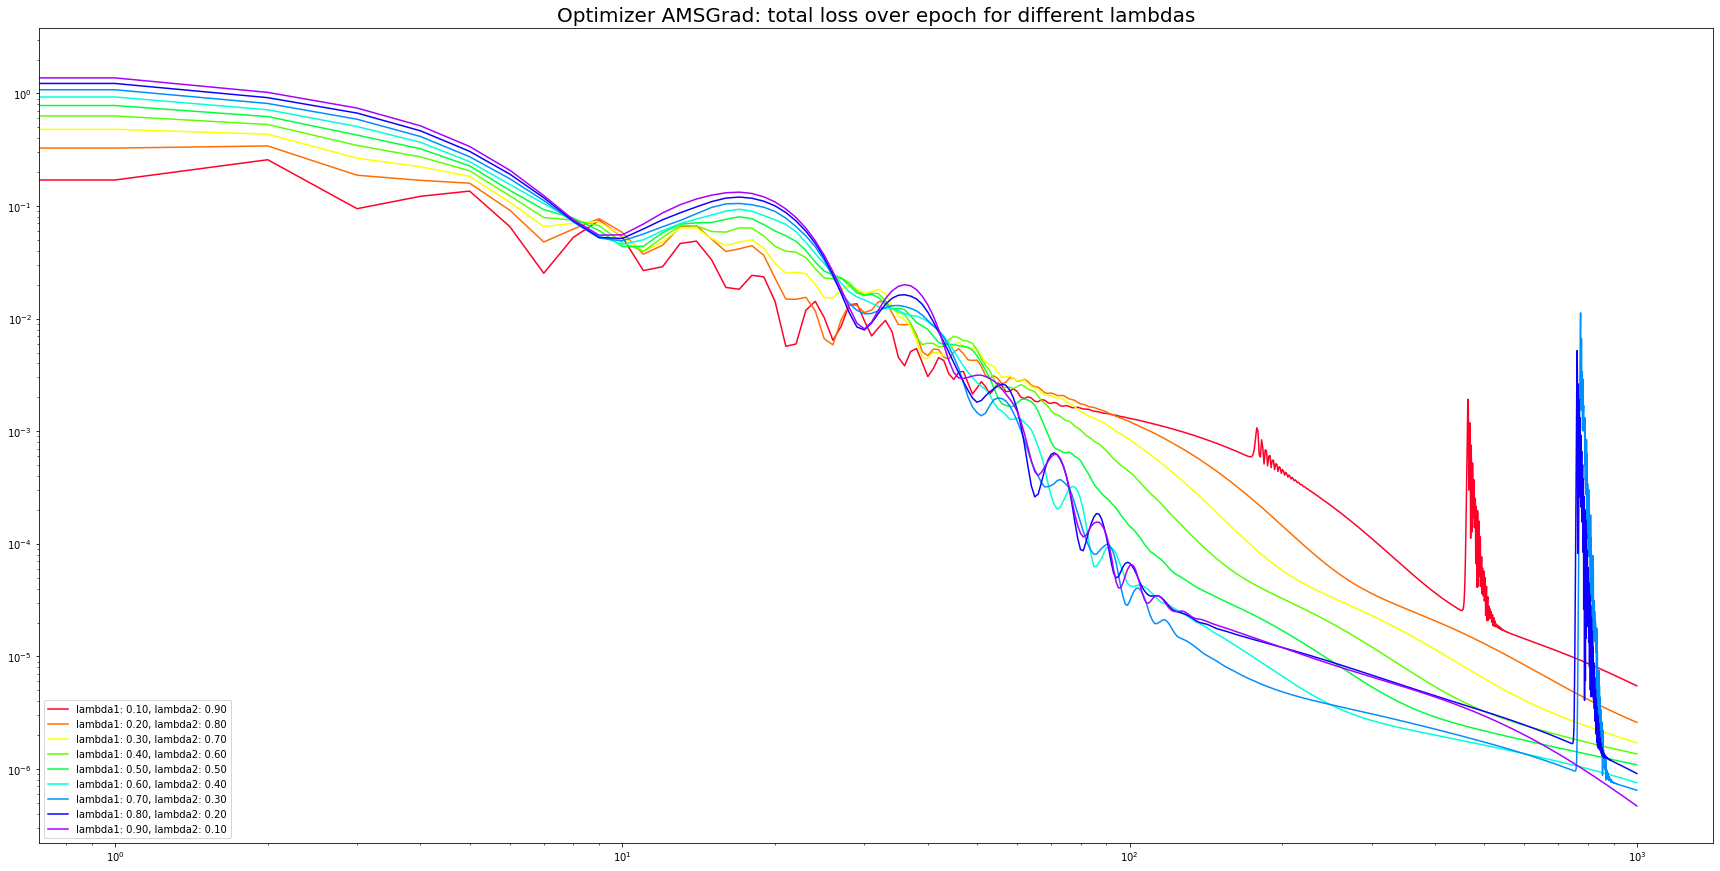

In [24]:
labels = []

NUM_COLORS = len(params)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in range(len(params)):
    labels.append('lambda1: ' + "{:.2f}".format(params[i]) + ', lambda2: ' + "{:.2f}".format(1 - params[i]))

for i in range(len(params)):
    ax.semilogy(results_adam[i][1][0])

legend = plt.legend(labels, loc='lower left')
plt.xscale('log') 
plt.title('Optimizer AMSGrad: total loss over epoch for different lambdas', fontdict = {'fontsize' : 20})